In [1]:
import cupy as cp
import numpy as np
from numpy.random import seed, normal
import matplotlib.pyplot as plt
import time

In [2]:
def gauss(x, x_0, sigma):
    """
    PDF function of normal distribution
    x_0, sigma: mean and std of the normal distribution
    """
    return 1*np.exp(-((x-x_0) / sigma) ** 2)

def gen_rand_pop(N_spin, k, sigma, min_pop):
    """
    Returns randomly generated population distribution following normal given standard deviation
    Here the maximum detuning is by default 3*sigma
    By default round up, if after rounding up, the class contains fewer than min_pop spins, discard class
    """
    det = np.linspace(0, 3*sigma, k)
    interval = 3*sigma/k
    prob = np.asarray([gauss((i+.5)*interval, 0, sigma) for i in range(k)])
    prob_sum = np.sum(prob)
    pop = np.ceil(N_spin/prob_sum*prob)
    keep = np.where(pop>=min_pop)
    pop = pop[keep]
    new_k = pop.size
    return pop, det, new_k

def ind_where(arr, target, tol):
    """
    Returns the center index of when the array reaches the target value within a tolerance
    """
    pts = np.where(abs(arr) - target <tol)
    center = np.take(pts, len(pts)//2)
    return center


def unit_time(gk, N_spin, kappa):
    """
    Returns the unit time as defined for Dicke superradiance
    """
    Omega_0 = 2*gk
    lim = Omega_0*np.sqrt(N_spin)
    if kappa < 1.5*lim:
        print("Warning: not in the overdamped regime")
    Gc = Omega_0**2/kappa
    Tr = 1/Gc/N_spin
    return Tr

def delay_time(gk, N_spin, kappa, theta):
    """
    Returns the theoretical delay time for Dicke superradiance
    qinit: float
        Initial excitation J-M, in mean field context, N_spin/2 * (1+cos(theta))
    """
    Tr = unit_time(gk, N_spin, kappa)
    qinit = N_spin/2 * (1+np.cos(theta))
    if N_spin > 1000:
        Td =  Tr * np.log(N_spin/(qinit+1))
    else:
        Td = Tr * (np.sum([1/(1+i) for i in range(N_spin)])-np.log(qinit+1))
    return Td


In [3]:
class sys:
    def __init__(self, pop_inclass, delta_a, delta_c, gk, theta, phi, cav_decay, spin_decay, spin_dephase):
        """
        Initialize basic icputs of the system
        pop_inclass : cp.array
            Contains the number of spins in each class arranged by index
        delta_a : cp.array
            Contains the detuning of the spins in each class arranged by index
        delta_c : float
            Cavity detuning from pump laser
        gk : float
            Universal coupling strength
        theta,phi : float
            Bloch vector: cos(theta/2)|g> + sin(theta/2)exp(i*phi)|e>
            theta = pi: excited
        cav_decay : float
            Cavity decay rate
        spin_decay : float
            Local spin decay rate
        spin_dephase : float
            Local spin dephase rate
        """
        self.pop_inclass = pop_inclass
        self.k = cp.size(pop_inclass) # Total number of classes (ensembles)
        self.delta_a = delta_a
        self.delta_c = delta_c
        self.gk = gk
        self.theta = theta
        self.phi = phi
        self.kappa = cav_decay
        self.gamma = spin_decay
        self.Gamma = spin_dephase
        
        # Convenient parameters to use
        self.w_spin = self.delta_a - 1j*(self.gamma/2 + self.Gamma)
        self.w_spin_r = cp.tile(self.w_spin, self.k).reshape(self.k, self.k) # For convenience
        self.w_cav = self.delta_c - 0.5j*self.kappa

        # Cavity pumping is set to 0 by default
        self.F = 0.

        # Initialize the mean field
        self.initialize()

    def initialize(self):
        """
        Inizializes the mean field matrices
        """
        G = cp.cos(self.theta/2) # Coefficient of ground state
        E = cp.sin(self.theta/2)*cp.exp(1j*self.phi) # Coefficient of excited state

        self.a = 0.+ 0j
        self.ad = cp.conjugate(self.a)
        self.ada = 0.
        self.a2 = 0.

        self.sz = -cp.cos(self.theta)*cp.ones(self.k)
        self.sm = G*E*cp.ones(self.k)
        self.sp = cp.conjugate(E)*G*cp.ones(self.k)

        self.a_sz = cp.zeros(self.k, dtype=np.cfloat)
        self.a_sm = cp.zeros(self.k, dtype=np.cfloat)
        self.a_sp = cp.zeros(self.k, dtype=np.cfloat)

        self.sz_sm = 0.25*cp.sin(2*self.theta)*cp.exp(-1j*self.phi)\
                     * cp.ones((self.k, self.k), dtype=np.cfloat)
        self.sz_sz = cp.cos(self.theta)**2\
                     * cp.ones((self.k, self.k), dtype=np.cfloat)
        self.sm_sm = 0.25*cp.sin(self.theta)**2\
                     * cp.ones((self.k, self.k), dtype=np.cfloat)
        self.sp_sm = G**2* cp.abs(E)**2\
                     * cp.ones((self.k, self.k), dtype=np.cfloat)
    
    """
    Functions to calculate mean-field increments at each time step
    """

    def cal_da(self):
        return (-1j * self.w_cav * self.a - 1j * self.gk * sum(self.pop_inclass
                 * self.sm) - 1j * self.F) 
    
    def cal_da2(self):
        return (-2j * self.w_cav * self.a2 - 2j * self.gk * cp.sum(self.pop_inclass
                 * self.a_sm) - 2j * self.F * self.a)
    
    def cal_dada(self):
        """
        Returns a real number: Intrafield cavity photons
        """
        return cp.real(-2 * self.gk * cp.sum(self.pop_inclass * cp.imag(self.a_sp))
                 - 2 * self.F * cp.imag(self.a) - self.kappa * self.ada)

    def cal_dsz(self):
        """
        Returns a real array (self.k): Average spin inversion in each class
        """
        return cp.real(4 * self.gk * cp.imag(self.a_sp) - self.gamma * (1 + self.sz))
    
    def cal_dsm(self):
        return (-1j * self.w_spin * self.sm + 1j * self.a_sz * self.gk)
    
    def cal_da_sz(self):
        return (-1j * self.w_cav * self.a_sz - 1j * self.gk * (-self.sm 
                 - cp.diagonal(self.sz_sm)) - 2j * self.gk * ((self.a2 * self.sp
                 + 2 * self.a * self.a_sp - 2 * self.a**2 * self.sp)
                 - (self.ad * self.a_sm + self.a * cp.conjugate(self.a_sp)
                 + self.ada * self.sm - 2 * cp.abs(self.a)**2 * self.sm))
                 - self.gamma * (self.a + self.a_sz) - 1j * self.F * self.sz
                 - 1j * self.gk * cp.sum(self.sz_sm * self.pop_inclass[..., None], axis=0))
    
    def cal_da_sm(self):
        return (-1j * (self.w_spin + self.w_cav) * self.a_sm 
                 + 1j * self.gk * (cp.diagonal(self.sm_sm) + 2 * self.a_sz * self.a 
                 + self.a2 * self.sz - 2 * self.a**2 * self.sz) 
                 - 1j * self.F * self.sm - 1j * self.gk * cp.sum(self.sm_sm 
                 * self.pop_inclass[..., None], axis=0))

    def cal_da_sp(self):
        return (1j * (cp.conj(self.w_spin) - self.w_cav) * self.a_sp 
                 - .5j * self.gk * (1 - self.sz) + 1j * self.gk * cp.diagonal(self.sp_sm)
                 -1j * self.gk * cp.sum(self.sp_sm * self.pop_inclass[..., None], axis=0) 
                 - 1j * self.gk * ((1 + self.ada) * self.sz 
                 + 2 * cp.real(self.a * cp.conjugate(self.a_sz))
                 - 2 * cp.abs(self.a)**2 * self.sz) -1j * self.F * self.sp)

    def cal_dsm_sm(self):
        return (-1j * (self.w_spin_r+self.w_spin_r.T) * self.sm_sm 
                 + 1j * self.gk * (self.a * self.sz_sm
                 + self.a_sz * cp.vstack(self.sm) + self.sz * cp.vstack(self.a_sm)
                 - self.a * self.sz * cp.vstack(self.sm)) 
                 + 1j * self.gk * (self.a * cp.conjugate(self.sz_sm).T 
                 + self.a_sm * cp.vstack(self.sz) + self.sm * cp.vstack(self.a_sz)
                 - 2 * self.a * self.sm * cp.vstack(self.sz)))
    
    def cal_dsz_sz(self):
        return (4 * self.gk * ((self.a_sp * cp.vstack(self.sz) 
                 + self.sp * cp.vstack(self.a_sz) + self.a * cp.conjugate(self.sz_sm).T 
                 - 2 * self.a * self.sp * cp.vstack(self.sz))
                 + (self.a_sp.T * self.sz + self.a_sz * cp.vstack(self.sp)
                 + self.a * cp.conjugate(self.sz_sm) 
                 - 2 * self.a * cp.vstack(self.sp) * self.sz))
                 + self.gamma * (cp.tile(self.sz, self.k).reshape(self.k, self.k).T
                 + self.sz_sz))

    def cal_dsz_sm(self):
        return ((-1j * self.w_spin_r + self.gamma) * self.sz_sm 
                 + 1j * self.gk * (self.a_sz * cp.vstack(self.sz)
                 + cp.vstack(self.a_sz)*self.sz + self.a * self.sz_sz
                 - 2 * self.a * self.sz * cp.vstack(self.sz)) 
                 - 2j * self.gk * (self.a_sp * cp.vstack(self.sm) 
                 + cp.vstack(self.a_sm) * self.sp + self.a * self.sp_sm
                 - 2 * self.a * self.sp * cp.vstack(self.sm)
                 - (cp.conjugate(self.a_sp) * cp.vstack(self.sm) 
                 + cp.conjugate(self.a_sp).T * self.sm + self.ad * self.sm_sm
                 - 2 * self.ad * self.sm * cp.vstack(self.sm)))
                 - self.gamma * cp.tile(self.sm, self.k).reshape(self.k, self.k).T)

    def cal_dsp_sm(self):
        return (-1j * (self.w_spin_r - self.w_spin_r.T) * self.sp_sm
                 + 1j * (self.a_sp * cp.vstack(self.sz) 
                 + cp.vstack(self.a_sz) * self.sp + self.a * cp.conjugate(self.sz_sm).T
                 - 2 * self.a * self.sp * cp.vstack(self.sz))
                 - 1j * (cp.conjugate(self.a_sz) * cp.vstack(self.sm)
                 + cp.conjugate(self.a_sp).T * self.sz + self.ad * self.sz_sm
                 - 2 * self.ad * self.sz * cp.vstack(self.sm)))
    
    def update(self, F, dt):
        """
        Update the mean-field values for one time step of size dt
        """
        self.F = F

        self.a += self.cal_da() * dt
        self.ad = cp.conjugate(self.a)
        self.ada += self.cal_dada() * dt
        self.a2 += self.cal_da2() * dt

        self.sz += self.cal_dsz() * dt
        self.sm += self.cal_dsm() * dt
        self.sp = cp.conjugate(self.sm)

        self.a_sz += self.cal_da_sz() * dt
        self.a_sm += self.cal_da_sm() * dt
        self.a_sp += self.cal_da_sp() * dt

        self.sz_sm += self.cal_dsz_sm() * dt
        self.sz_sz += self.cal_dsz_sz() * dt
        self.sm_sm += self.cal_dsm_sm() * dt
        self.sp_sm += self.cal_dsp_sm() * dt

    def solve_constant(self, tlist):
        """
        Returns 
        tlist: np.array
            All the time steps with constant dt
        F_t: np.array
            Cavity pump amplitude with respect to time
        """
        intervals = np.size(tlist)
        F_t = cp.zeros(intervals)
        dt = tlist[-1]/intervals
        e_ada = cp.zeros(intervals)
        e_sz = cp.zeros((intervals, self.k))
        e_sp_sm = cp.zeros((intervals, self.k))
        print("Start solving, dt = ", dt)
        start = time.time()
        for t in range(intervals):
            self.update(F_t[t], dt)
            e_ada[t] = self.ada
            e_sz[t] = self.sz
            e_sp_sm[t] = cp.diagonal(self.sp_sm)
        end = time.time()
        print(end-start)

        return [cp.asnumpy(e_ada), cp.asnumpy(e_sz), cp.asnumpy(e_sp_sm)]


    def solve_adapt(self, endtime, F, min_dt=1e-6):
        """
        tlist: np.array
           (0, endtime, default intervals)
        F: float
            The cavity pump amplitude
        min_dt: float
            The smallest allowed time step
        mode: str
            {'constant', 'adapt'} 
        """
        mode = mode.lower()
        time_now = 0
        loop_count = 0
        dt = max(0.25 * 1/max(self.kappa, self.gamma, self.Gamma,
                 0.5 * self.gk * max(self.pop_inclass) * cp.sqrt(max(self.pop_inclass)))
                 , min_dt) # default by fastest oscillation or a set minimum
        print("Start solving, dt = ", dt)
        start = time.time()
        while (endtime - time_now > 2 * dt):
            loop_count += 1
            # Adaptive
            dt = 2
            time_now += dt
        end = time.time()
        print(end-start)

In [64]:
pop_inclass = cp.asarray([1000, 1000, 1000, 1000])
delta_a = cp.asarray([20, 50, -30, 10])
delta_c = 0
gk = 1.6
theta = cp.pi/2
phi = 0
cav_decay = 1600
spin_decay = 0
spin_dephase = 0

In [65]:
test_sys = sys(pop_inclass, delta_a, delta_c, gk, theta, phi, 
                 cav_decay, spin_decay, spin_dephase)
    
tlist = np.linspace(0,1,int(1e3))
F_t = cp.zeros(int(1e3))
results = test_sys.solve_constant(tlist)

Start solving, dt =  0.001
3.7058849334716797


In [66]:
Td_theory = delay_time(gk, 10000, cav_decay, theta)
Td_simulate = tlist[ind_where(results[1], 0.0, 0.5)]
print(Td_theory)
print(Td_simulate)

0.010827300008707484
0.0


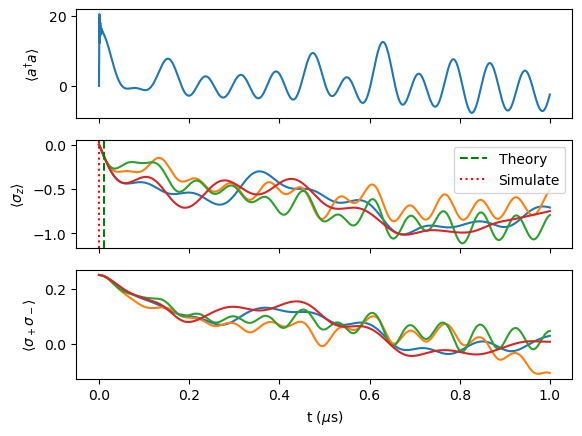

In [67]:
fig, ax = plt.subplots(3,1, sharex='col')
ax[0].plot()
ax[2].set_xlabel(r"t ($\mu$s)")
ax[0].set_ylabel(r"$\langle a^{\dagger}a \rangle$")
ax[1].set_ylabel(r"$\langle \sigma_z\rangle$")
ax[2].set_ylabel(r"$\langle \sigma_+\sigma_-\rangle$")

ax[0].plot(tlist, results[0])
ax[1].plot(tlist, results[1])
ax[1].axvline(Td_theory, color="green", ls="--", label="Theory")
ax[1].axvline(Td_simulate, color="red", ls=":", label="Simulate")
ax[1].legend()
ax[2].plot(tlist, results[2])
